In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
import networkx as nx
import torch

## HypBench: Hyperbolic Benchmark for Graph Neural Network Performance

HypBench [1] is a a comprehensive benchmarking framework for graph machine learning, focusing on the performance of GNNs across varied network structures. Utilizing the geometric soft configuration model in hyperbolic space, one can generate synthetic networks with realistic topological properties and node feature vectors. This approach enables to assess the impact of network properties, such as topology-feature correlation, degree distributions, local density of triangles (or clustering), and homophily, on the effectiveness of different GNN architectures.


HypBench relies on the $\mathbb{S}^1/\mathbb{H}^2$ model [2,3] to generate synthetic networks and on bipartite-$\mathbb{S}^1/\mathbb{H}^2$ model for generating synthetic node features [4] (represented as a bipartite graph).  

---
**$\mathbb{S}^1$ model**

Each node $i=1,\dots,N$ has two hidden variables:

- **Angular coordinate** $\theta_i \in [0,2\pi)$, sampled uniformly at random, encoding similarity.  
- **Hidden degree** $\kappa_i$, drawn from a power-law distribution $P(\kappa) \sim \kappa^{-\gamma}$, encoding popularity.

The circle radius is $R = N / (2\pi)$. The angular distance between nodes is
$$
\Delta\theta_{ij} = \pi - \left| \pi - \lvert \theta_i - \theta_j \rvert \right| .
$$

The connection probability is
$$
p_{ij} = \frac{1}{1 + \left( \frac{R\,\Delta\theta_{ij}}{\mu \,\kappa_i \kappa_j} \right)^{\beta}},
$$
where $\mu$ fixes the average degree, $\beta > 1$ tunes the level of clustering coefficient.

---
**$\mathbb{H}^2$ mapping**

The $\mathbb{S}^1$ model maps naturally to the hyperbolic disk $\mathbb{H}^2$.

- Radial coordinate:
$$
r_i = R_h - 2 \ln \kappa_i ,
$$
so high-degree nodes lie closer to the center.

- Hyperbolic distance:
$$
x_{ij} \approx r_i + r_j + 2 \ln \frac{\Delta\theta_{ij}}{2} .
$$

- Connection probability (Fermi–Dirac form):
$$
p_{ij} = \frac{1}{1 + e^{\tfrac{\beta}{2}(x_{ij} - R_h)}} .
$$

This makes explicit that topology arises from the interplay of **popularity** (radial coordinate) and **similarity** (angular distance).

---
**Bipartite-$\mathbb{S}^1$ model for features**

To generate node attributes, one introduces a bipartite network between nodes $U$ and feature prototypes $F$.

- Nodes $u \in U$: angles $\theta_u = \theta$, hidden degrees $\kappa_u$.  
- Features $f \in F$: angles $\phi_f$, hidden degrees $\kappa_f$.  

The connection probability is
$$
p_{uf} = \frac{1}{1 + \left( \frac{R \, \Delta\theta_{uf}}{\mu_b \, \kappa_u \kappa_f} \right)^{\beta_b}} .
$$


---

[1] Aliakbarisani, R., Jankowski, R., Serrano, M., & Boguñá, M. (2024). Hyperbolic Benchmarking Unveils Network Topology-Feature Relationship in GNN Performance. arXiv preprint arXiv:2406.02772.

[2] Serrano, M. Á., Krioukov, D., & Boguná, M. (2008). Self-similarity of complex networks and hidden metric spaces. Physical review letters, 100(7), 078701.

[3] Krioukov, D., Papadopoulos, F., Kitsak, M., Vahdat, A., & Boguná, M. (2010). Hyperbolic geometry of complex networks. Physical Review E—Statistical, Nonlinear, and Soft Matter Physics, 82(3), 036106.

[4] Aliakbarisani, R., Serrano, M. Á., & Boguñá, M. (2025). Feature-enriched hyperbolic network geometry. Physical Review Research, 7(3), 033036.
    

In [2]:
from omegaconf import DictConfig
from topobench.data.loaders.graph.hypbench_dataset import HypBenchDatasetLoader

# Example parameters
params = DictConfig({
    "N_n": 2000,        # Number of nodes
    "beta": 2,          # Clustering coefficient control
    "gamma": 2.5,       # Power-law exponent for node degrees
    "kmean": 10.0,      # Mean degree in unipartite network
    "N_f": 500,         # Number of node features
    "beta_b": 1.5,      # Bipartite clustering control (topology-features correlation)
    "gamma_n": 2.5,     # Power-law exponent for node degrees in bipartite network
    "gamma_f": 2.5,     # Power-law exponent for feature degrees in bipartite network
    "kmean_n": 10.0,    # Mean node degree in bipartite network
    "N_c": 6,           # Number of classes
    "alpha": 8.0,       # Homophily strength
    "data_dir": "/tmp"  # Required by AbstractLoader, can be any path
})

loader = HypBenchDatasetLoader(params)
dataset = loader.load_dataset()

In [3]:
print(dataset.data.x.shape)  # Node features
print(dataset.data.y.shape)  # Labels

torch.Size([2000, 500])
torch.Size([2000])


/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_8735/3050551390.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print(dataset.data.x.shape)  # Node features
/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_8735/3050551390.py:2: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  print(dataset.data.y.shape)  # Labels


In [4]:
data = dataset.data

/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_8735/2168711401.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  data = dataset.data


In [5]:
data

Data(x=[2000, 500], edge_index=[2, 18444], y=[2000], thetas=[2000], kappas=[2000], radii=[2000], thetas_f=[500], kappas_f=[500], kappas_n=[2000], radii_n=[2000], radii_f=[500], num_nodes=2000, num_node_features=500, num_classes=6)

In [6]:
from torch_geometric.utils import to_networkx
g = to_networkx(data, to_undirected=True, node_attrs=['thetas', 'kappas', 'radii', 'y'])
print(g)

Graph with 2000 nodes and 9222 edges


Let us visualize the uniparite network with nodes' positions

100%|██████████████████████████████████████████████████████████████████████████████████████████| 9222/9222 [00:00<00:00, 11048.19it/s]


Text(0.5, 1.0, 'Unipartite network')

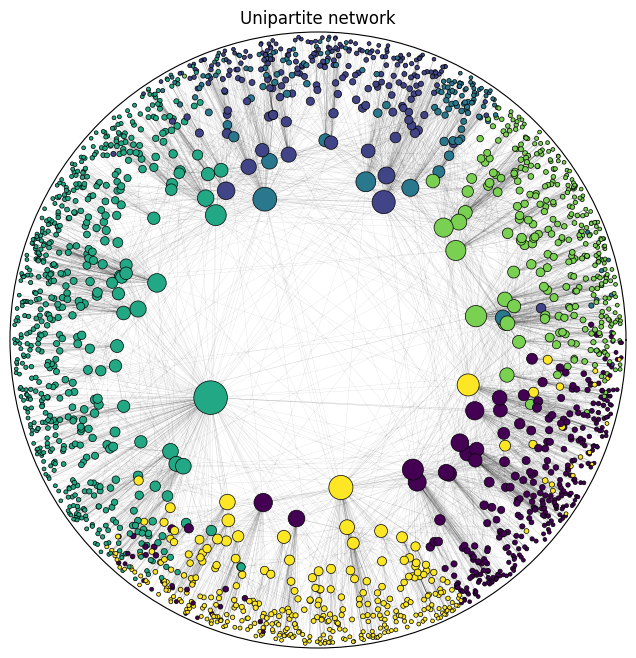

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

for source, target in tqdm(g.edges()):
    s = g.nodes[source]
    t = g.nodes[target] 
    ax.plot([s['thetas'], t['thetas']], [s['radii'], t['radii']], 
            color='black', alpha=0.3, linewidth=0.1)

thetas = nx.get_node_attributes(g, 'thetas').values()
radii = list(nx.get_node_attributes(g, 'radii').values())
kappas = list(nx.get_node_attributes(g, 'kappas').values())
labels = list(nx.get_node_attributes(g, 'y').values())

ax.scatter(thetas, radii, c=labels, edgecolors='black',
           s=2*np.array(kappas), alpha=1, linewidths=0.5, zorder=30)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, np.max(radii) + 0.2)
ax.set_title('Unipartite network')

As well as the bipartite network encoding the node features

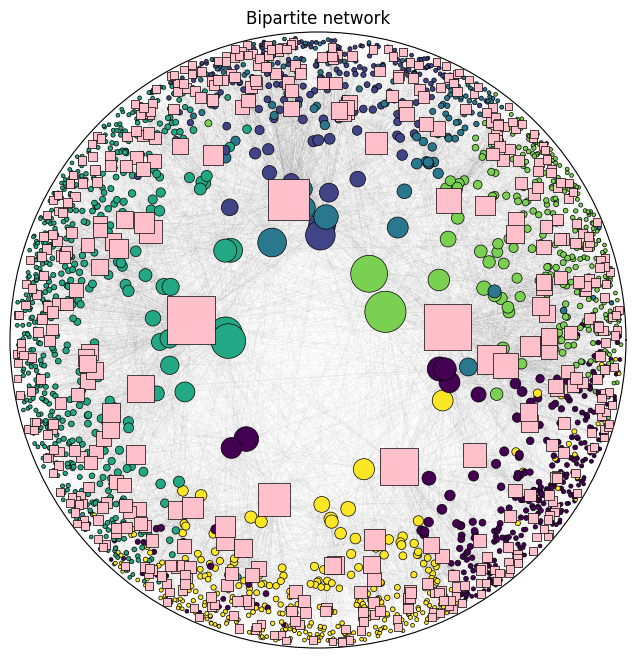

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

thetas_n = data.thetas
radii_n = data.radii_n
kappas_n = np.array(data.kappas_n)
labels = data.y

thetas_f = data.thetas_f
radii_f = data.radii_f
kappas_f = np.array(data.kappas_f)

for s, t in torch.nonzero(data.x):
    ax.plot([thetas_n[s], thetas_f[t]], [radii_n[s], radii_f[t]], 
            color='black', alpha=0.2, linewidth=0.05)

ax.scatter(thetas_n, radii_n, c=labels, edgecolors='black',
           s=2*kappas_n, alpha=1, linewidths=0.5, zorder=30)
ax.scatter(thetas_f, radii_f, marker='s', edgecolors='black',
           alpha=1, s=2*kappas_f, color='pink',linewidths=0.5, zorder=30)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, np.max(radii_n) + 0.2)
ax.set_title('Bipartite network')
plt.show()

### Measuring the impact of each HypBench parameter


HypBench offers a flexible control over the network topology and node feature characteristics, let us explore how each parameter affects the network properties.

### Parameter $\beta$ -- controling the clustering coefficient

In [16]:
betas = [1.2, 1.5, 2.0, 3.0, 5.0]
clustering_coefficients = []

for b in tqdm(betas):
    params = DictConfig({
        "N_n": 1000,        # Number of nodes
        "beta": b,          # Clustering coefficient control
        "gamma": 2.5,       # Power-law exponent for node degrees
        "kmean": 10.0,      # Mean degree in unipartite network
        "N_f": 500,         # Number of node features
        "beta_b": 1.5,      # Bipartite clustering control (topology-features correlation)
        "gamma_n": 2.5,     # Power-law exponent for node degrees in bipartite network
        "gamma_f": 2.5,     # Power-law exponent for feature degrees in bipartite network
        "kmean_n": 10.0,    # Mean node degree in bipartite network
        "N_c": 6,           # Number of classes
        "alpha": 8.0,       # Homophily strength
        "data_dir": "/tmp"  # Required by AbstractLoader, can be any path
    })

    loader = HypBenchDatasetLoader(params)
    dataset = loader.load_dataset()
    g = to_networkx(dataset.data, to_undirected=True)
    clustering_coefficients.append(nx.average_clustering(g))

  0%|                                                                                                           | 0/5 [00:00<?, ?it/s]/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_8735/106357730.py:22: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  g = to_networkx(dataset.data, to_undirected=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.71s/it]


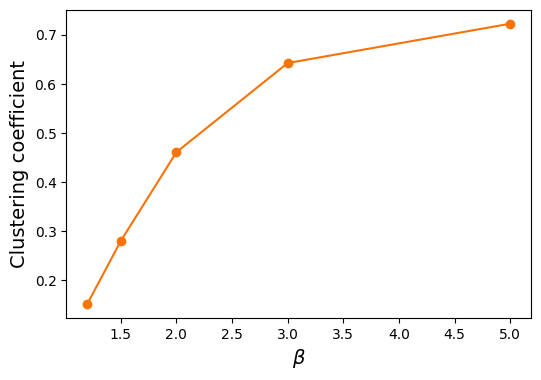

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(betas, clustering_coefficients, 'o-', color='xkcd:orange')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel(r'Clustering coefficient', fontsize=14)
plt.show()

### Parameter $\gamma$ -- controling the degree distribution

In [39]:
gammas = [2.2, 2.5, 5.0]
degrees = []

for g in tqdm(gammas):
    params = DictConfig({
        "N_n": 2000,        # Number of nodes
        "beta": 2.0,          # Clustering coefficient control
        "gamma": g,       # Power-law exponent for node degrees
        "kmean": 10.0,      # Mean degree in unipartite network
        "N_f": 500,         # Number of node features
        "beta_b": 1.5,      # Bipartite clustering control (topology-features correlation)
        "gamma_n": 2.5,     # Power-law exponent for node degrees in bipartite network
        "gamma_f": 2.5,     # Power-law exponent for feature degrees in bipartite network
        "kmean_n": 10.0,    # Mean node degree in bipartite network
        "N_c": 6,           # Number of classes
        "alpha": 8.0,       # Homophily strength
        "data_dir": "/tmp"  # Required by AbstractLoader, can be any path
    })

    loader = HypBenchDatasetLoader(params)
    dataset = loader.load_dataset()
    g = to_networkx(dataset.data, to_undirected=True)
    degree_freq = nx.degree_histogram(g)
    deg = range(len(degree_freq))
    degrees.append((degree_freq, deg))

  0%|                                                                                                           | 0/3 [00:00<?, ?it/s]/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_8735/2789493483.py:22: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  g = to_networkx(dataset.data, to_undirected=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.93s/it]


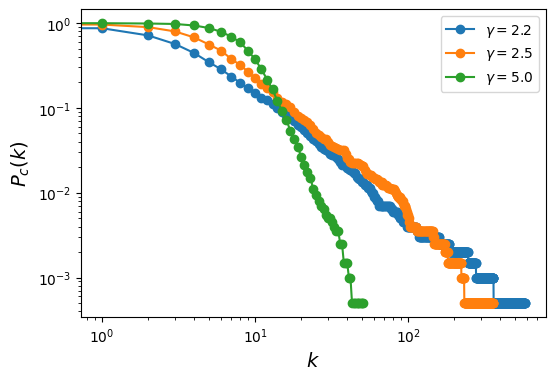

In [53]:
plt.figure(figsize=(6, 4)) 
for (deg_freq, deg), gamma in zip(degrees, gammas):
    plt.loglog(deg[:-1], 1 - np.cumsum(deg_freq[:-1] / np.sum(deg_freq)), 'o-', label=rf'$\gamma={gamma}$')

plt.legend()
plt.xlabel(r'$k$', fontsize=14)
plt.ylabel(r'$P_c(k)$', fontsize=14)
plt.show()

### Parameter $\beta_b$ -- controling the topology-features correlation / bipartite clustering coefficient

In [68]:
from networkx.algorithms import bipartite
from scipy import sparse

betas_b = [1.5, 2.0, 3.0, 5.0, 10.0]
bipartite_clustering_coefficients = []

for beta_b in tqdm(betas_b):
    params = DictConfig({
        "N_n": 1000,        # Number of nodes
        "beta": 2.0,          # Clustering coefficient control
        "gamma": 2.5,       # Power-law exponent for node degrees
        "kmean": 10.0,      # Mean degree in unipartite network
        "N_f": 1000,         # Number of node features
        "beta_b": beta_b,      # Bipartite clustering control (topology-features correlation)
        "gamma_n": 2.5,     # Power-law exponent for node degrees in bipartite network
        "gamma_f": 2.5,     # Power-law exponent for feature degrees in bipartite network
        "kmean_n": 10.0,    # Mean node degree in bipartite network
        "N_c": 6,           # Number of classes
        "alpha": 8.0,       # Homophily strength
        "data_dir": "/tmp"  # Required by AbstractLoader, can be any path
    })

    loader = HypBenchDatasetLoader(params)
    dataset = loader.load_dataset()

    # Convert node features to bipartite graph
    B = bipartite.from_biadjacency_matrix(sparse.csr_matrix(dataset.data.x.numpy()))
    bipartite_clustering_coefficients.append(bipartite.average_clustering(B))   


  0%|                                                                                                           | 0/5 [00:00<?, ?it/s]/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_8735/2267460045.py:27: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  B = bipartite.from_biadjacency_matrix(sparse.csr_matrix(dataset.data.x.numpy()))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.17s/it]


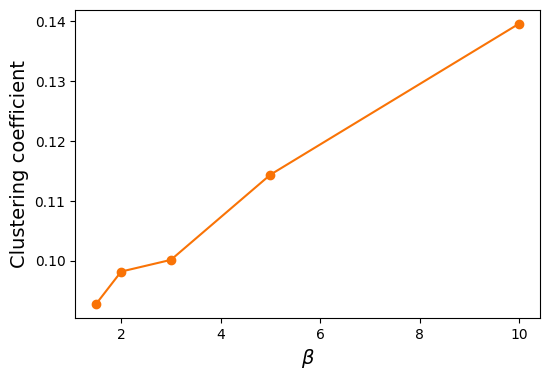

In [69]:
plt.figure(figsize=(6, 4))
plt.plot(betas_b, bipartite_clustering_coefficients, 'o-', color='xkcd:orange')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel(r'Clustering coefficient', fontsize=14)
plt.show()

### Parameter $\alpha$ -- controling the level of homophily

In [71]:
def compute_homophily(g):
    H = 0
    for u in g.nodes():
        label = g.nodes[u]['y']
        h = 0
        neighbours = list(g.neighbors(u))
        for n in neighbours:
            if g.nodes[n]['y'] == label:
                h += 1
                
        if len(neighbours) > 0:
            h /= len(neighbours)

        H += h
    H /= len(g)
    return H

In [87]:
from networkx.algorithms import bipartite
from scipy import sparse

alphas = [0, 1, 2.5, 5, 7.5, 10]
number_of_clusters = 5
homophily_levels = []

for alpha in tqdm(alphas):
    params = DictConfig({
        "N_n": 1000,        # Number of nodes
        "beta": 1.5,        # Clustering coefficient control
        "gamma": 3.0,       # Power-law exponent for node degrees
        "kmean": 10.0,      # Mean degree in unipartite network
        "N_f": 1000,        # Number of node features
        "beta_b": 2.0,      # Bipartite clustering control (topology-features correlation)
        "gamma_n": 2.5,     # Power-law exponent for node degrees in bipartite network
        "gamma_f": 2.5,     # Power-law exponent for feature degrees in bipartite network
        "kmean_n": 10.0,    # Mean node degree in bipartite network
        "N_c": number_of_clusters,  # Number of classes
        "alpha": alpha,     # Homophily strength
        "data_dir": "/tmp"  # Required by AbstractLoader, can be any path
    })

    loader = HypBenchDatasetLoader(params)
    dataset = loader.load_dataset()
    g = to_networkx(dataset.data, to_undirected=True, node_attrs=['thetas', 'kappas', 'radii', 'y'])
    homophily_levels.append(compute_homophily(g))

  0%|                                                                                                           | 0/6 [00:00<?, ?it/s]/var/folders/nt/6fr0tc0s5pgbfmsdg568khgw0000gn/T/ipykernel_8735/2809407414.py:26: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  g = to_networkx(dataset.data, to_undirected=True, node_attrs=['thetas', 'kappas', 'radii', 'y'])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.51s/it]


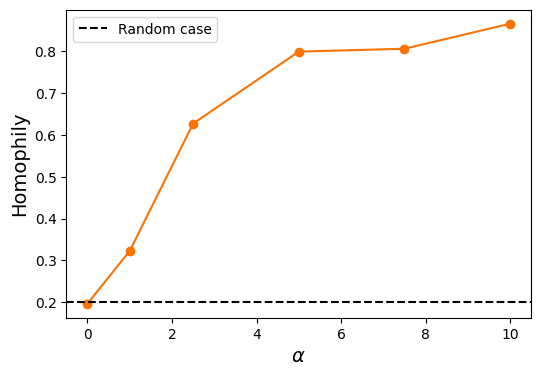

In [88]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, homophily_levels, 'o-', color='xkcd:orange')
plt.axhline(1/number_of_clusters, color='black', linestyle='--', label='Random case')
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'Homophily', fontsize=14)
plt.legend()
plt.show()